# [주차 수요 예측](https://dacon.io/competitions/official/235745/overview/description)

# 1. 데이터 전처리

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rc 

plt.rcParams["axes.unicode_minus"] = False 
rc("font", family="Malgun Gothic")
# %matplotlib inline 
get_ipython().run_line_magic("matplotlib", "inline")

In [48]:
train = pd.read_csv('./parking_data/train.csv')
test = pd.read_csv('./parking_data/test.csv')
age_gender_info = pd.read_csv('./parking_data/age_gender_info.csv')

## 0) 오류 데이터 삭제

In [49]:
# 2,3번 데이터 - 삭제 요망
# 1번 데이터 - 모델 학습 후 삭제 여부 판단

# 2번 데이터 오류 
train = train[train['단지코드'] != 'C2085']
train = train[train['단지코드'] != 'C1397']
train = train[train['단지코드'] != 'C2431']
train = train[train['단지코드'] != 'C1649']
train = train[train['단지코드'] != 'C1036']

# 3번 데이터 오류 
train = train[train['단지코드'] != 'C1095']
train = train[train['단지코드'] != 'C2051']
train = train[train['단지코드'] != 'C1218']
train = train[train['단지코드'] != 'C1894']
train = train[train['단지코드'] != 'C2483']
train = train[train['단지코드'] != 'C1502']
train = train[train['단지코드'] != 'C1988']

## 1) 컬럼별 null값 확인

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   임대건물구분                        2869 non-null   object 
 3   지역                            2869 non-null   object 
 4   공급유형                          2869 non-null   object 
 5   전용면적                          2869 non-null   float64
 6   전용면적별세대수                      2869 non-null   int64  
 7   공가수                           2869 non-null   float64
 8   자격유형                          2869 non-null   object 
 9   임대보증금                         2300 non-null   object 
 10  임대료                           2300 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2662 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 13  단지내

In [241]:
# for col in train.columns:
#     print(col, train[col].unique(),'\n')

--> null값 존재 컬럼: 임대보증금, 임대료, 도보 10분거리 내 지하철역 수

## 1. 임대료, 임대보증금 컬럼
```
1) 데이터 타입 float로 변환
2) null값 --> train 데이터의 평균값 또는 0으로 대체
```

### 1) 데이터 타입 float로 변환

In [51]:
train.loc[train['임대보증금']=='-','임대보증금'] = np.nan
train.loc[train['임대료']=='-','임대료'] = np.nan

train['임대보증금'] = train['임대보증금'].astype(float)
train['임대료'] = train['임대료'].astype(float)

In [52]:
test.loc[test['임대보증금']=='-','임대보증금'] = np.nan
test.loc[test['임대료']=='-','임대료'] = np.nan

test['임대보증금'] = test['임대보증금'].astype(float)
test['임대료'] = test['임대료'].astype(float)

### 2) null값 --> train 데이터의 평균값 또는 0으로 대체
- 임대보증금 or 임대료가 null값이 데이터를 공급유형별, 지역별로 나누어서 살펴보기

#### 1. 임대보증금/임대료의 null 값 - (공급유형-임대상가) 인 데이터부터 처리하기

In [113]:
train['공급유형'].value_counts()

국민임대         1727
임대상가          562
행복주택          202
공공임대(10년)     175
영구임대          152
공공임대(50년)      31
공공임대(분납)        7
공공분양            7
장기전세            3
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [110]:
train[train['임대보증금'].isnull()]['공급유형'].value_counts()

임대상가    562
국민임대      8
공공분양      7
행복주택      4
Name: 공급유형, dtype: int64

- 전체 데이터 공급유형 컬럼:임대상가인 개수 - 562개인데, 임대보증금이 null값인 데이터에서 공급유형 컬럼: 임대상가인 경우 - 562개이다.

==> 공급유형이 임대상가인 데이터는 임대보증금이 모두 null값이다

--> null값은 지역별 평균값 or 0으로 대체(둘 중 모델 학습 성능 더 좋은 것으로 채택)

In [212]:
# 이 데이터는 전부 null값이다
train[train['공급유형']=='임대상가']['지역'].value_counts()

부산광역시      220
대전광역시      113
경상남도        97
충청남도        76
강원도         31
제주특별자치도     25
Name: 지역, dtype: int64

In [217]:
# 1. null -> 평균값
for col in train[train['공급유형']=='임대상가']['지역'].value_counts().index:
    train.loc[train['지역']==col,'임대료'] = train['임대료'].fillna(train[train['지역']==col]['임대료'].mean())
    train.loc[train['지역']==col,'임대보증금'] = train['임대보증금'].fillna(train[train['지역']==col]['임대보증금'].mean())
    
# 2. null -> 0

In [220]:
train[train['임대보증금'].isnull()]['공급유형'].value_counts(), train[train['임대료'].isnull()]['공급유형'].value_counts()

(국민임대    3
 Name: 공급유형, dtype: int64,
 장기전세    3
 국민임대    3
 Name: 공급유형, dtype: int64)

#### 2. 나머지 null값 처리

In [221]:
train.loc[train['공급유형'] == '국민임대', '임대보증금'] = train['임대보증금'].fillna(0)
train.loc[train['공급유형'] == '국민임대', '임대료'] = train['임대료'].fillna(0)
train.loc[train['공급유형'] == '장기전세', '임대료'] = train['임대료'].fillna(0)

In [222]:
train[train['임대보증금'].isnull()]['공급유형'].value_counts(), train[train['임대료'].isnull()]['공급유형'].value_counts()

(Series([], Name: 공급유형, dtype: int64), Series([], Name: 공급유형, dtype: int64))

## 2. 도보 10분거리 내 지하철역 수, 버스정류장 수

### 1) 지하철역 수
- train, test 데이터에 모두 null값이 존재
- 전체 데이터의 분포는 0이 상당수를 차지하고 있음
=> null값 0으로 대체

In [63]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum(), test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

(207, 42)

In [66]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts(), test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].value_counts()

(0.0    2223
 1.0     400
 2.0      33
 3.0       6
 Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64,
 0.0    881
 1.0     64
 2.0     35
 Name: 도보 10분거리 내 지하철역 수(환승노선 수 반영), dtype: int64)

--> 대부분이 0이므로 null값 0으로 대체

In [71]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

0

### 2) 버스정류장 수
- null값 존재하지 않음
- 데이터 분포 확인 -> test 데이터에 outlier 존재 (10분 내 거리에 버스정류장 수: 50개)

In [74]:
train['도보 10분거리 내 버스정류장 수'].isnull().sum(), test['도보 10분거리 내 버스정류장 수'].isnull().sum()

(0, 0)

In [76]:
train['도보 10분거리 내 버스정류장 수'].unique(), test['도보 10분거리 내 버스정류장 수'].unique()

(array([ 3.,  1.,  2.,  6., 10.,  5.,  4.,  7., 12., 14.,  8.,  0., 20.,
        11., 16., 15., 19.]),
 array([ 2.,  3., 16.,  6.,  1.,  4.,  5.,  8., 10., 13.,  7., 11., 50.,
        12., 14., 18., 15., 19., 17.]))

In [78]:
train['도보 10분거리 내 버스정류장 수'].value_counts()

2.0     774
3.0     716
4.0     485
1.0     270
5.0     162
6.0     153
8.0      99
10.0     80
7.0      65
12.0     22
20.0     15
15.0     11
16.0      6
19.0      4
11.0      3
14.0      2
0.0       2
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

In [79]:
test['도보 10분거리 내 버스정류장 수'].value_counts()

2.0     252
3.0     166
4.0     134
1.0     117
5.0     112
6.0      85
7.0      48
8.0      33
16.0     13
11.0     11
15.0     10
50.0      9
18.0      7
14.0      6
12.0      5
17.0      4
10.0      4
19.0      3
13.0      3
Name: 도보 10분거리 내 버스정류장 수, dtype: int64

In [60]:
test[test['도보 10분거리 내 버스정류장 수']==50]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
383,C1852,898,아파트,경기도,국민임대,39.59,219,6.0,H,23720000.0,197230.0,0.0,50.0,785.0
384,C1852,898,아파트,경기도,국민임대,39.72,56,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
385,C1852,898,아파트,경기도,국민임대,39.72,44,6.0,A,23720000.0,197230.0,0.0,50.0,785.0
386,C1852,898,아파트,경기도,국민임대,46.90,46,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
387,C1852,898,아파트,경기도,국민임대,46.90,22,6.0,A,37454000.0,259660.0,0.0,50.0,785.0
388,C1852,898,아파트,경기도,국민임대,46.90,225,6.0,H,37454000.0,259660.0,0.0,50.0,785.0
389,C1852,898,아파트,경기도,국민임대,51.93,136,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
390,C1852,898,아파트,경기도,국민임대,51.93,44,6.0,H,45193000.0,308350.0,0.0,50.0,785.0
391,C1852,898,아파트,경기도,국민임대,59.61,106,6.0,H,61674000.0,370790.0,0.0,50.0,785.0


--> 버스정류장 수가 50인 경우, train 데이터의 평균값 or 최댓값으로 변환하여 처리

*평균값 vs 최댓값 둘 다 모델 돌려봐야 알 것 같다**

In [99]:
test.loc[test['도보 10분거리 내 버스정류장 수']==50, '도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].mean()

In [98]:
train['도보 10분거리 내 버스정류장 수'].mean(), train['도보 10분거리 내 버스정류장 수'].max()

(3.709654932032067, 20.0)

In [100]:
test[test['도보 10분거리 내 버스정류장 수']==50]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수


---

In [233]:
train.isnull().sum()

단지코드                            0
총세대수                            0
임대건물구분                          0
지역                              0
공급유형                            0
전용면적                            0
전용면적별세대수                        0
공가수                             0
자격유형                            0
임대보증금                           0
임대료                             0
도보 10분거리 내 지하철역 수(환승노선 수 반영)    0
도보 10분거리 내 버스정류장 수              0
단지내주차면수                         0
등록차량수                           0
dtype: int64

In [231]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   임대건물구분                        2869 non-null   object 
 3   지역                            2869 non-null   object 
 4   공급유형                          2869 non-null   object 
 5   전용면적                          2869 non-null   float64
 6   전용면적별세대수                      2869 non-null   int64  
 7   공가수                           2869 non-null   float64
 8   자격유형                          2869 non-null   object 
 9   임대보증금                         2869 non-null   float64
 10  임대료                           2869 non-null   float64
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 13  단지내

In [232]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
10,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
11,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0
12,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0


## 2. Train 데이터 feature간 연관성

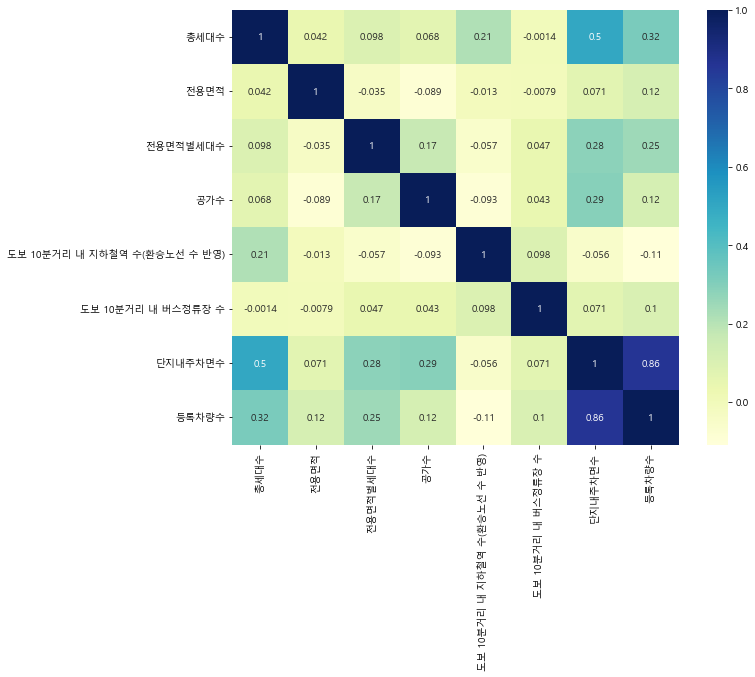

In [227]:
plt.figure(figsize=(10,8))
sns.heatmap(data=parking.corr(), annot=True, cmap="YlGnBu")
plt.show()

--> feature 간 상관관계 높은 것 어떻게 처리?

In [8]:
parking.corr()

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
총세대수,1.000000,0.042271,0.098205,0.068192,0.213843,-0.001446,0.501488,0.316703
전용면적,0.042271,1.000000,-0.035479,-0.089201,-0.013111,-0.007866,0.071260,0.115453
전용면적별세대수,0.098205,-0.035479,1.000000,0.166472,-0.056680,0.047112,0.281989,0.247085
공가수,0.068192,-0.089201,0.166472,1.000000,-0.093334,0.043285,0.289819,0.118121
도보 10분거리 내 지하철역 수(환승노선 수 반영),0.213843,-0.013111,-0.056680,-0.093334,1.000000,0.098380,-0.055544,-0.108592
도보 10분거리 내 버스정류장 수,-0.001446,-0.007866,0.047112,0.043285,0.098380,1.000000,0.070696,0.103752
단지내주차면수,0.501488,0.071260,0.281989,0.289819,-0.055544,0.070696,1.000000,0.859216
등록차량수,0.316703,0.115453,0.247085,0.118121,-0.108592,0.103752,0.859216,1.000000


In [240]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,82940.0,0.0,3.0,624.0,205.0
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
10,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,107130.0,0.0,3.0,624.0,205.0
11,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0
12,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,149760.0,0.0,3.0,624.0,205.0


In [239]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,189840.0,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,249930.0,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,249930.0,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,296780.0,0.0,2.0,683.0
